In [1]:
# Classical
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# PyTorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch import optim

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [15,10]

In [3]:
torch.__version__

'0.4.0'

In [4]:
data = pd.read_csv('./data/digit-recognizer/train.csv')
data = np.array(data)

In [5]:
class MNIST(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __getitem__(self, index):
        X = data[index][1:]
        y = data[index][0]
        return (torch.from_numpy(X).float()/256, 
                torch.LongTensor(np.array([y])))
    
    def __len__(self):
        return len(self.data)

In [6]:
class SimpleNeuralNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.linears = nn.ModuleList([
            nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)
        ])
        
    def forward(self, x):
        for lin in self.linears:
            lin_x = lin(x)
            x = F.relu(lin_x)
        return F.log_softmax(lin_x, dim=1)

In [7]:
def init_net():
    return SimpleNeuralNet([IMAGE_SIZE, 100, 100, 10])

In [8]:
mnist = MNIST(data)
data_dl = DataLoader(mnist, batch_size = 256, shuffle=True, num_workers=0)

In [9]:
epochs = 3
criterion = nn.NLLLoss()

In [10]:
## Create architecture
IMAGE_SIZE = 28 * 28
net = init_net()

# Weight/biases
wbs = [(lin.weight, lin.bias) for lin in net.linears]
losses = []
lr = 1e-3

In [11]:
print("[Epoch, Loss]")
for epoch in range(epochs):
    for i, batch in enumerate(data_dl):
        inputs, labels = Variable(batch[0]), Variable(batch[1])
        outputs = net(inputs)
        
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        for w, b in wbs:
            w.data -= lr * w.grad.data
            b.data -= lr * b.grad.data
            w.grad.data.zero_()
            b.grad.data.zero_()
    print("[{}, {}]".format(epoch, loss.data))

[Epoch, Loss]
[0, 2.3067426681518555]
[1, 2.2946691513061523]
[2, 2.2895169258117676]


In [12]:
sgd_losses = [(l.data.numpy()) for l in losses]
sgd_log_losses_ = [np.log(l) for l in sgd_losses]

Text(0.5,1,'Vanilla SGD')

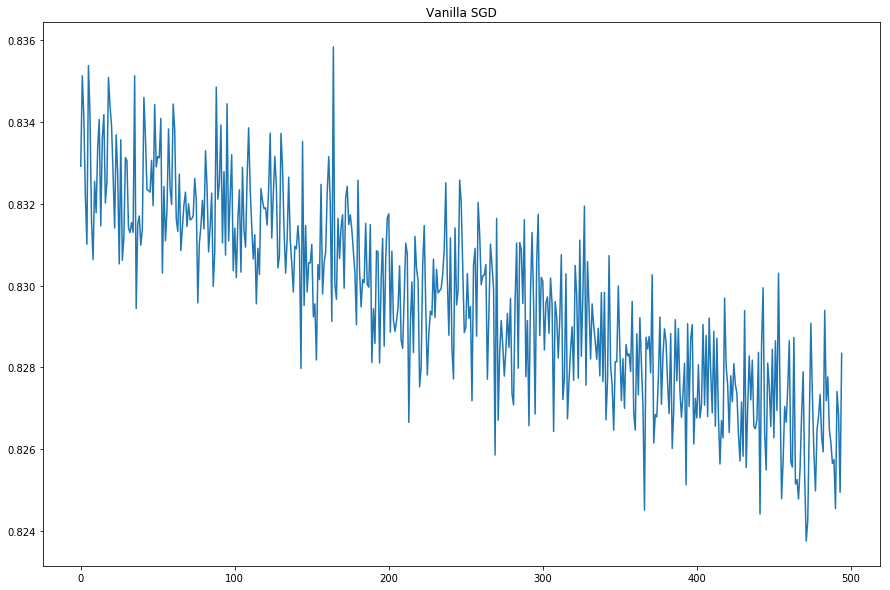

In [13]:
plt.plot(sgd_log_losses_)
plt.title("Vanilla SGD")

## Adding momentum

We can greatly improve neural net performance by reducing variance in the gradient.
We do so through a linear interpolocation between past gradients and the current one.

https://stats.stackexchange.com/questions/179915/whats-the-difference-between-momentum-based-gradient-descent-and-nesterovs-ac

In [34]:
net = init_net()
wbs = [(lin.weight, lin.bias) for lin in net.linears]
losses = []

# parameters
lr = 1e-3
rho = .9
epochs = 3

# momentum trackers
weight_v_prev = [0 for i in range(len(wbs))]
bias_v_prev = [0 for i in range(len(wbs))]

In [35]:
print("[Epoch, Loss]")
for epoch in range(epochs):
    for i, batch in enumerate(data_dl):
        inputs, labels = Variable(batch[0]), Variable(batch[1])
        outputs = net(inputs)
        
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        for i, wb in enumerate(wbs):
            w = wb[0]
            b = wb[1]
            weight_v_curr = rho * weight_v_prev[i] + lr * w.grad.data
            bias_v_curr = rho * bias_v_prev[i] + lr * b.grad.data
            
            weight_v_prev[i] = weight_v_curr
            bias_v_prev[i] = bias_v_curr
            w.data -= weight_v_curr
            b.data -= bias_v_curr
            
            w.grad.data.zero_()
            b.grad.data.zero_()
    print("[{}, {}]".format(epoch, loss.data))

[Epoch, Loss]
[0, 2.21382212638855]
[1, 2.1321024894714355]
[2, 1.9148629903793335]


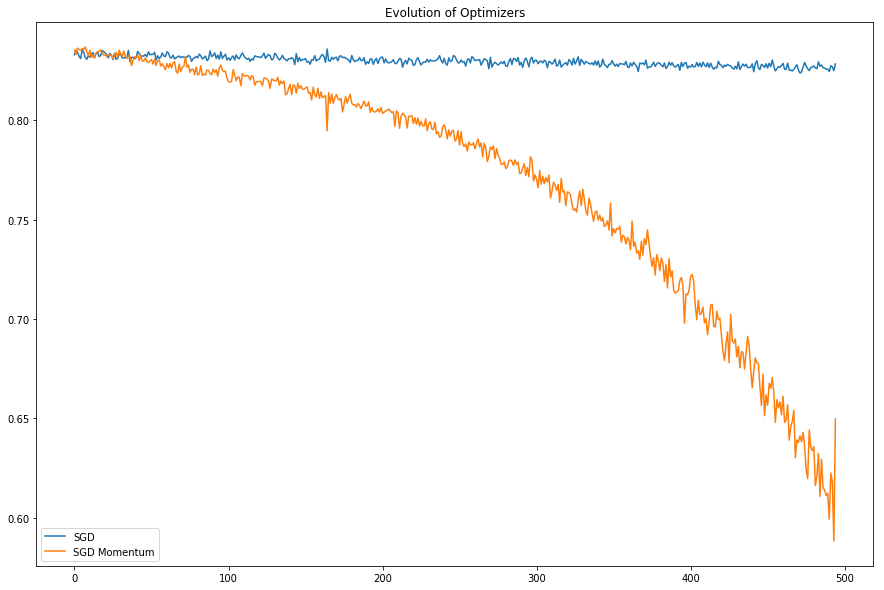

In [36]:
sgdmom_losses_ = [(l.data.numpy()) for l in losses]
sgdmom_log_losses_ = [np.log(l) for l in sgdmom_losses_]

plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum'))   

## Nesterov's Optimizer

There is extra value in reducing the noise/variance in the gradients. We can do
so by peeking into what a gradiend will be in the future and adjusting for it

In [44]:
### init architecture
net = init_net()

### get weight, bias objects
wbs = [(lin.weight, lin.bias) for lin in net.linears]

### keep track of training loss
losses = []

###params
lr = 1e-3
rho = 0.9
weight_v_prev = [0 for i in range(len(wbs))] # initialize momentum term
bias_v_prev = [0 for i in range(len(wbs))] # initialize momentum term

epochs = 3

In [45]:
print("[Epoch, Loss]")
for epoch in range(epochs):
    for n, batch in enumerate(data_dl):
        inputs, labels = batch
        inputs, labels = Variable(batch[0]), Variable(batch[1])
        outputs = net(inputs)
        
        # compute loss
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        
        # update weights 
        for i, wb in enumerate(wbs):
            w = wb[0]
            b = wb[1]
            
            w_save = w.data
            b_save = b.data
            # Update the weights
            # peek into the 'future' to see the next gradient
            w.data -= rho * weight_v_prev[i]
            peek_outputs = net(inputs)
            peek_loss = criterion(outputs, labels.squeeze(-1))
            peek_loss.backward(retain_graph=True)
            peek_grad = w.grad.data
                     
            weight_v_new = rho * weight_v_prev[i] + lr * peek_grad
            weight_v_prev[i] = weight_v_new
            w.data = w_save
            
            # final update
            w.data -= weight_v_new
            net.zero_grad()
            
            
            # update biases
            # peek into the 'future' to see the next gradient
            b_original = b.data
            b.data -= rho * bias_v_prev[i]
            
            # calculate loss and gradient, to see how would it be
            peek_outputs = net(inputs)
            peek_loss = criterion(outputs, labels.squeeze(-1))
            peek_loss.backward(retain_graph=True)
            peek_grad = b.grad.data
            
            bias_v_new = rho * bias_v_prev[i] + lr * peek_grad
            bias_v_prev[i] = bias_v_new
            b.data = b_save
            b.data -= bias_v_new
            
            # zero all gradients
            net.zero_grad()
    print("[{}, {}]".format(epoch, loss.data))

[Epoch, Loss]
[0, 2.240557909011841]
[1, 1.7444864511489868]
[2, 0.8024006485939026]


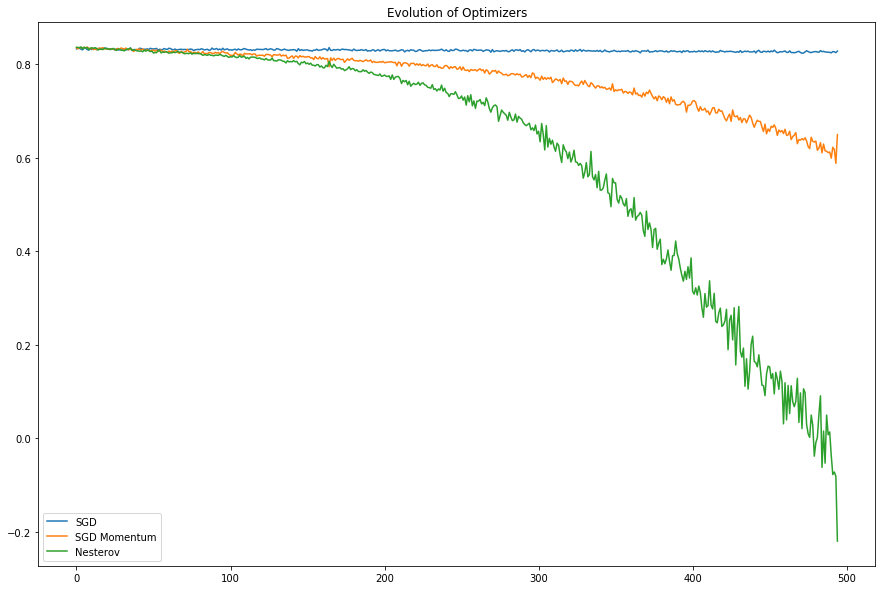

In [46]:
nesterov_losses_ = [(l.data.numpy()) for l in losses]
nesterov_log_losses_ = [np.log(l) for l in nesterov_losses_]
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
plt.plot(nesterov_log_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum', 'Nesterov'))

## Adagrad

Adaptive subgradient methods is a wonderful way to mitigate fine-tuning learning
rates. When the gradient is high, their effective learning rate is reduced, while
weights with smaller updatess (sparse) will have their learning rate increased.

https://xcorr.net/2014/01/23/adagrad-eliminating-learning-rates-in-stochastic-gradient-descent/

In [71]:
net = init_net()
wbs = [(lin.weight, lin.bias) for lin in net.linears]
losses = []

# params
lr = .001
grads_squared = [[torch.zeros(wb[0].size()), torch.zeros(wb[1].size())] for wb in wbs]
noise = 1e-8

epochs = 3

In [72]:
### Training 
for epoch in range(epochs):
    for i, batch in enumerate(data_dl):
        inputs, labels = Variable(batch[0]), Variable(batch[1])
        outputs = net(inputs)
        
        # compute loss and gradients
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        # update weights 
        for i, wb in enumerate(wbs):
            w = wb[0]
            b = wb[1]
            
            w.data -= lr*(w.grad.data / torch.sqrt(grads_squared[i][0] + noise))
            b.data -= lr*(b.grad.data / torch.sqrt(grads_squared[i][1] + noise))
            
            grads_squared[i][0] += w.grad.data*w.grad.data
            grads_squared[i][1] += b.grad.data*b.grad.data
            
            # zero the gradients
            w.grad.data.zero_()
            b.grad.data.zero_()
    print("[{}, {}]".format(epoch, loss.data))

[0, 0.5947005748748779]
[1, 0.3276205360889435]
[2, 0.5123748779296875]


In [73]:

adagrad_losses_ = [(l.data.numpy()) for l in losses]
adagrad_log_losses_ = [np.log(l) for l in adagrad_losses_]

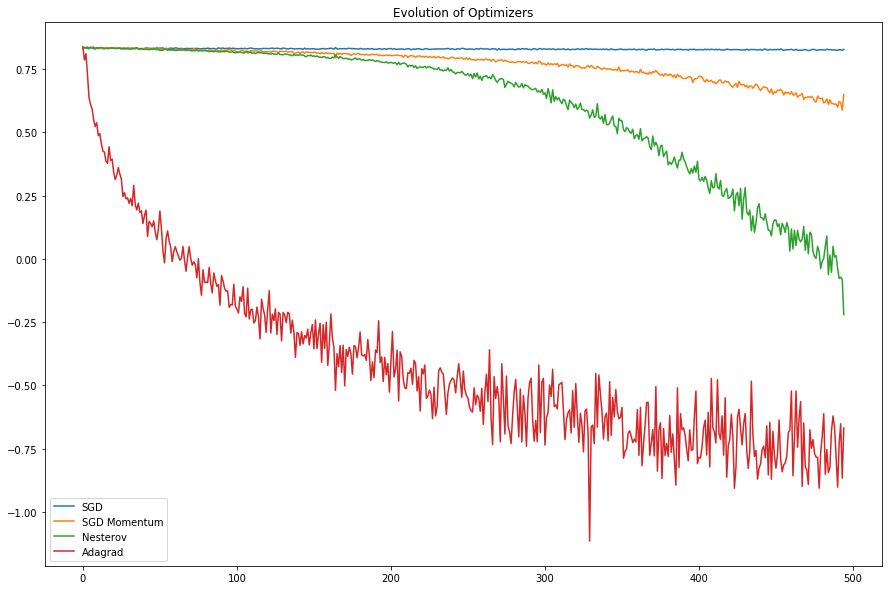

In [74]:
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
plt.plot(nesterov_log_losses_)
plt.plot(adagrad_log_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum', 'Nesterov', 'Adagrad'))